In [18]:
import numpy as np
import emcee
import matplotlib.pyplot as pl
from matplotlib.pyplot import cm 
import matplotlib.mlab as mlab
import phoebe
# from scipy.stats import norm #for python3

In [19]:
#next, set hyperparameters used for emcee (MCMC)

nwalkers = 20
niter = 10
prior_boxes = [(-2.,0.),(-0.5,0.5),(-0.5,0.)]
ndim = len(prior_boxes)
sigma = 0.1

In [20]:
#generate initial guesses
def rpars(prior_boxes):
    return [np.random.rand() * (p[1]-p[0]) + p[0] for p in prior_boxes]

#determine log probability using this function:

def lnprob(z):

    # make a model using the values the sampler generated
    model = q(z[0],z[1],z[2],x)

    # use chi^2 to compare the model to the data:
    chi2 = 0.
    for i in range (len(x)):
            chi2+=((noisy[i]-model[i])**2)/(sigma**2)

    # calculate lnp
    lnp = -0.5*chi2

    return lnp

In [21]:
#run it all together:

def run(prior_boxes, nwalkers, niter, ndim):

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(prior_boxes) for i in range(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the 
    # lnprob function. With this setup, the first parameter
    # in the lnprob function is the output from the sampler (the paramter 
    # positions).
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob)

    pos, prob, state = sampler.run_mcmc(p0, niter)

    for i in range(ndim):
        pl.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = pl.hist(y, 200, normed=1, color="b", alpha=0.45)
        pl.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)       
        print ("mu = ", "sigma = ", mu, sigma)

        bf = mlab.normpdf(bins, mu, sigma)
#         bf = norm.pdf(bins, mu, sigma) #python 3
        l = pl.plot(bins, bf, 'k--', linewidth=2.0)
        
        pl.xlabel('bins')
        pl.ylabel('histogram?')
    pl.show()
    return pos

In [22]:
#making synthetic binary using phoebe
logger = phoebe.logger(clevel='WARNING')
b = phoebe.default_binary()

times = np.linspace(0,1,51)
b.add_dataset('lc', times=times, dataset='lc01')

#making irradiation method none VASTLY reduces run time
b.get_parameter(context='compute', qualifier='irrad_method').set_value("none")

#reducing number of triangles for star models
b.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
b.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

In [23]:
#setting specific orbital parameters
b['incl@binary@orbit@component'] = 90.0
b['q@binary@orbit@component'] = 0.5
b['pblum@primary@dataset'] = 1.0*np.pi

b['requiv@primary@star@component'] = 1.0
b['requiv@secondary@star@component'] = 0.5

b.run_compute()

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

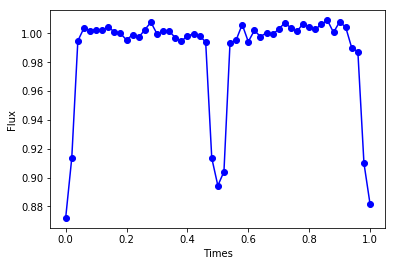

In [24]:
#now adding noise
fluxes = b['fluxes@latest@model'].get_value()/np.median(b['fluxes@latest@model'].get_value())
sigmas = np.full((len(times)), 0.01)
mean = 1.0
noise = np.random.normal(mean, sigmas, fluxes.shape)
noisy = (fluxes + noise)/np.median((fluxes + noise)) #normalized

pl.plot(times, noisy, "bo-")
pl.xlabel("Times")
pl.ylabel("Flux")
pl.show()

In [25]:
#next, set hyperparameters used for emcee (MCMC)

nwalkers = 20
niter = 10
prior_boxes = [(-2.,0.),(-0.5,0.5),(-0.5,0.)]
ndim = len(prior_boxes)
sigma = 0.1


#making hyperparameters
nwalkers = 10
niter = 2

#Now we have our data, we need to set the hyperparamters required to run emcee. 
#Here the prior boxes provide the lower and upper limits for the phoebe parameter values. 
#We will select the order to be incl, requiv1, requiv2, mass ratio
init_dist = [(86.4,87.3),(1.15,1.25),(0.725,0.825),(0.675,0.725)]

#Here we will set uninformed priors, but you can have informed priors such as gaussian priors:
priors = [(80.,90),(1.1,1.3),(0.7,0.9),(0.6,0.9)]

In [26]:
#make a new model to fit synthetic data
mod = phoebe.default_binary()

#compute_phases isn't a kwarg?
mod.add_dataset('lc', times = times, fluxes=fluxes, sigmas=sigmas,compute_phases=np.linspace(0,1.,51), passband='Kepler:mean')


Tue, 29 Oct 2019 20:50 BUNDLE       WARNING 'compute_phases' not a recognized kwarg


<ParameterSet: 15 parameters | contexts: compute, dataset>

In [27]:
#reducing parameter space to run faster again
mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

In [28]:
mod.run_compute()

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [29]:
#this will calc. luminosity passband at each iteration
# mod.set_value('pblum_mode',value='dataset-scaled')
#^^^ DOESN"T WORK

In [30]:
#creating initial guesses
def rpars(init_dist):
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

# Instate the priors such that if a parameter falls outside the prior range, 
# the value will be set to negative infinity and the model will not be accepted:
def lnprior(priors, values):
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

#determine log probabilitiy with this function
def lnprob(z):

    mod['incl@binary@orbit@component'] = z[0]
    mod['requiv@primary@star@component'] = z[1]
    mod['requiv@secondary@star@component'] = z[2]
    mod['q@binary@orbit@component'] = z[3]
    
    lnp = lnprior(priors,z)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        mod.run_compute()

        # use chi^2 to compare the model to the data:
        chi2 = 0.
        for dataset in mod.get_model().datasets:
            chi2+=np.sum(mod.compute_residuals(dataset=dataset, as_quantity=False)**2/sigmas**2)
        # calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf

In [31]:
#put it all together
def run(init_dist, nwalkers, niter):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(init_dist) for i in xrange(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. With this setup, the value z
    # in the lnprob function, is the output from the sampler.
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob)
    
    #pos is the position of the walkers in parameter space
    #prob is the probability of the given "pos" positions
    #state is the state of the random number generator
    pos, prob, state = sampler.run_mcmc(p0, niter)

    for i in range(ndim):
        pl.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = pl.hist(y, 200, normed=1, color="b", alpha=0.45)#, histtype="step")
        pl.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print "mu = ", mu
        print "sigma = ",sigmas

        bf = mlab.normpdf(bins, mu, sigma)
        l = pl.plot(bins, bf, 'k--', linewidth=2.0)
        pl.xlabel('bins')
        pl.ylabel('histogram?')
    pl.show()
    return pos

Tue, 29 Oct 2019 20:50 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:50 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:50 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:50 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:50 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:51 BUNDLE       WARNING overwriting model: latest
Tue, 29 Oct 2019 20:

mu =  86.70591231534037
sigma =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


/Users/felizd/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


mu =  1.1886077024722517
sigma =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
mu =  0.7800269778212681
sigma =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
mu =  0.6957873540705217
sigma =  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


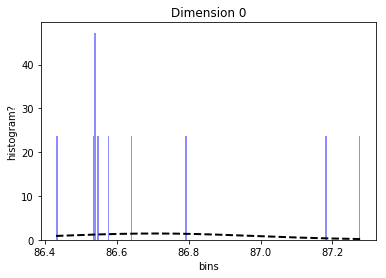

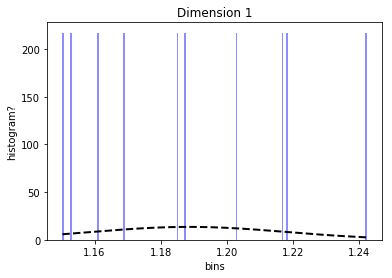

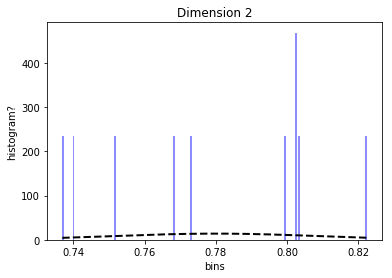

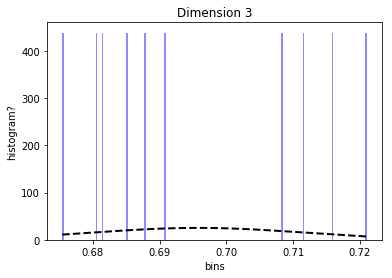

In [32]:
pos = run(init_dist, nwalkers, niter)

In [33]:
color=cm.rainbow(np.linspace(0,1,nwalkers))
for i,c in zip(range(nwalkers),color):
  
    #pl.figure()
    
    # Set all the parameter values
    mod['incl@binary@orbit@component'] = pos[-1-i,0]
    mod['requiv@primary@star@component'] = pos[-1-i,1]
    mod['requiv@secondary@star@component'] = pos[-1-i,2]
    mod['q@binary@orbit@component'] = pos[-1-i,3]
        
    mod.run_compute(model='run{}'.format(i))

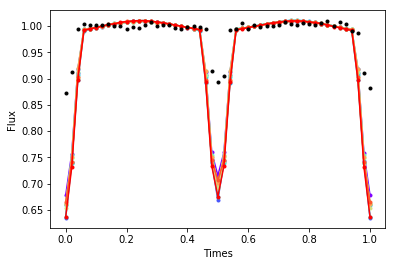

(51, 51, 51)


In [34]:
for i,c in zip(range(nwalkers),color):
    #model by itself seems offset, normalizing it fixes it.
    
    f=mod['fluxes@run{}'.format(i)].interp_value(times=times)
    
    model = f
    norm_model=f/np.median(f)
#     pl.plot(times,model,c=c,marker='.',linestyle='-')
    pl.plot(times,norm_model,c=c,marker='.',linestyle='-')

pl.xlabel("Times")
pl.ylabel("Flux")
pl.plot(times,noisy,"k.")
pl.show()

print(len(times),len(model),len(noisy))